In [2]:
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

import networkx as nx
import pennylane as qml

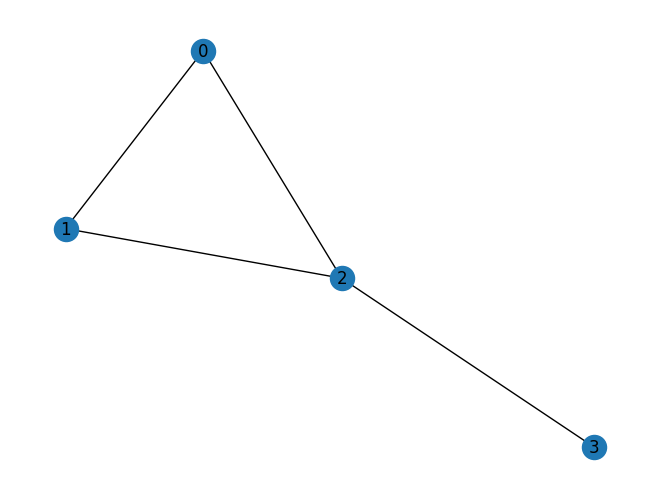

In [3]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3)] #定义边的列表
graph = nx.Graph(edges) #创建一个无向图
positions = nx.spring_layout(graph, seed=1) #计算节点的坐标位置，让图更美观

nx.draw(graph, with_labels=True, pos=positions) #绘制无向图，并显示节点的编号
plt.show() #显示图像

In [4]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)
#调用pennylane的函数，它根据输入的无向图生成两个哈密顿量，cost hamiltonian 和 mixer hamiltonian
print("Cost Hamiltonian", cost_h) #把他们打印出来
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian 0.75 * (Z(0) @ Z(1)) + 0.75 * Z(0) + 0.75 * Z(1) + 0.75 * (Z(0) @ Z(2)) + 0.75 * Z(0) + 0.75 * Z(2) + 0.75 * (Z(1) @ Z(2)) + 0.75 * Z(1) + 0.75 * Z(2) + 0.75 * (Z(2) @ Z(3)) + 0.75 * Z(2) + 0.75 * Z(3) + -1.0 * Z(0) + -1.0 * Z(1) + -1.0 * Z(2) + -1.0 * Z(3)
Mixer Hamiltonian 1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3)


In [5]:
def qaoa_layer(gamma, alpha): #定义一个QAOA层，每一层包括
    qaoa.cost_layer(gamma, cost_h) #成本层，对成本哈密顿量 施加酉变换 
    qaoa.mixer_layer(alpha, mixer_h)# mixer layer,对mix hamiltonian 施加酉变换
    #gamma 成本哈密顿量的优化参数
    # alpha mixer hamiltonian 的优化参数
    #这段代码将哈密顿量转化成QAOA的线路 

In [6]:
wires = range(4) #定义4个量子比特
depth = 2 #设定QAOA的层数


def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w) #初始化所有比特到均匀叠加态
    qml.layer(qaoa_layer, depth, params[0], params[1])


- **对每个比特施加 Hadamard 门**，让初始状态变成 **均匀叠加态**：
  $$
  |\psi\rangle = \frac{1}{\sqrt{2^n}} \sum_x |x\rangle
  $$

- 这样 **所有可能解的比特串都被同时考虑**，充分利用量子计算的并行性。

- `qml.layer(qaoa_layer, depth, params[0], params[1])`

- `depth = 2`，意味着执行 **2 轮 QAOA 变分层**。

- `params[0]` 和 `params[1]` 分别对应 **gamma 和 alpha 的优化参数**，用于调整 QAOA 线路。


In [7]:
dev = qml.device("qulacs.simulator", wires=wires)


@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

- 使用 `qml.device` **创建一个模拟器**，这里使用 **Qulacs** 作为后端。

- `"qulacs.simulator"`：表示 **使用 Qulacs 作为 PennyLane 的量子模拟器**，用于 **运行 QAOA 线路**。

- `wires=wires`：指定 **量子比特的数量**（对应图的顶点数）。

### Qulacs 是什么？

- Qulacs 是一个高性能的量子电路模拟器，**比 PennyLane 默认的 `default.qubit` 更快**。

- 适用于 **中等规模的 QAOA 计算**。

`@qml.qnode(dev)`：将 `cost_function` **变成一个量子节点（QNode）**，表示它运行在 `dev` 设备上（Qulacs 模拟器）。

`circuit(params)`：

- **执行 QAOA 线路**，`params` 是待优化的参数。

`qml.expval(cost_h)`：

- 计算成本哈密顿量 \( H_C \) 在 QAOA 线路最终状态的期望值。
- 目标是**最小化这个期望值**，因为 \( H_C \) 的最低值对应 **最优解**。


In [8]:
optimizer = qml.GradientDescentOptimizer()
steps = 70
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

- `optimizer = qml.GradientDescentOptimizer()`：创建一个 **梯度下降优化器**。

- `steps = 70`：设定优化 **迭代 70 次**。

- `params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)`

  - **初始化 QAOA 变分参数** \( (\gamma, \alpha) \)。
  - `requires_grad=True` 表示这些参数 **可训练**，用于优化 QAOA 线路。


In [9]:
for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

Optimal Parameters
[[0.59806352 0.94198485]
 [0.52797281 0.85552845]]


In [10]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

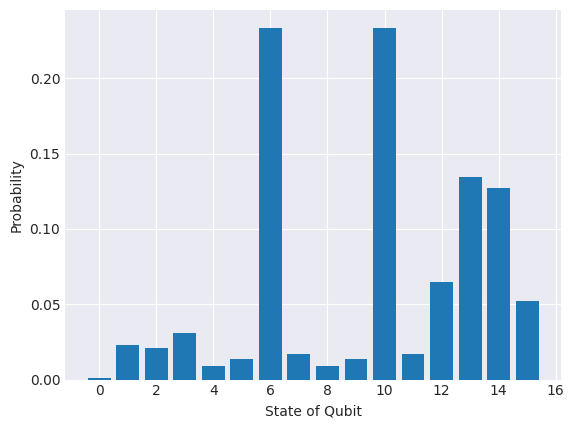

In [11]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")
plt.bar(range(2 ** len(wires)), probs)
plt.xlabel("State of Qubit")
plt.ylabel("Probability")
plt.show()

In [12]:
import matplotlib.pyplot as plt
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [13]:
reward_h = qaoa.edge_driver(nx.Graph([(0, 2)]), ["11"])

In [14]:
new_cost_h = cost_h + 2 * reward_h

In [15]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, new_cost_h)
    qaoa.mixer_layer(alpha, mixer_h)


def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])


@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(new_cost_h)


params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

Optimal Parameters
[[0.45959941 0.96095271]
 [0.27029962 0.78042396]]


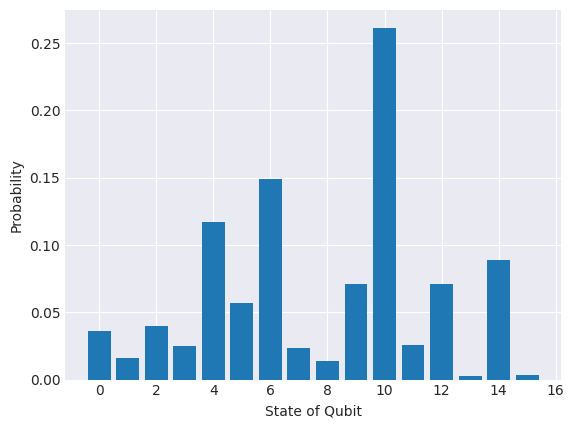

In [16]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

plt.style.use("seaborn-v0_8-darkgrid")
plt.bar(range(2 ** len(wires)), probs)
plt.xlabel("State of Qubit")
plt.ylabel("Probability")
plt.show()